In [ ]:
!pip install prophet

In [18]:
# Import packages
import numpy as np
import pandas as pd
from getpass import getpass
import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [2]:
secret = getpass()

··········


## Loading Data

In [31]:
api_key = secret
technical = 'time_series'
ticker = 'MSFT'  # ticker = "GOOGL"
interval = '1day'
order = 'asc'
start_date = '2021-01-03'
end_date = '2022-01-01'

api_url = f'https://api.twelvedata.com/{technical}?symbol={ticker}&start_date={start_date}&end_date={end_date}&interval={interval}&order={order}&apikey={api_key}'
data = requests.get(api_url).json()
df = pd.DataFrame(data['values'])
df

,datetime,open,high,low,close,volume
0,2021-01-04,222.53000,223.00000,214.81000,217.69000,37130100
1,2021-01-05,217.25999,218.52000,215.70000,217.89999,23823000
2,2021-01-06,212.17000,216.49001,211.94000,212.25000,35930700
3,2021-01-07,214.03999,219.34000,213.71001,218.28999,27694500
4,2021-01-08,218.67999,220.58000,217.03000,219.62000,22956200
...,...,...,...,...,...,...
247,2021-12-27,335.45999,342.48001,335.42999,342.45001,19947000
248,2021-12-28,343.14999,343.81000,340.32001,341.25000,15661500
249,2021-12-29,341.29999,344.29999,339.67999,341.95001,15042000
250,2021-12-30,341.91000,343.13000,338.82001,339.32001,15994500


In [32]:
df.isna().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [33]:
df.dtypes

datetime    object
open        object
high        object
low         object
close       object
volume      object
dtype: object

In [34]:
# Drop columns we don't need
df.drop(['open', 'high', 'low','volume'], axis=1, inplace=True)

In [35]:
# Change format of dataframe values to allow for modelling
df['datetime'] = pd.to_datetime(df['datetime'])
df['close'] = df['close'].astype(float)
df.dtypes

datetime    datetime64[ns]
close              float64
dtype: object

In [36]:
df.describe()

,close
count,252.000000
mean,275.941587
std,36.941615
min,212.250000
25%,244.097497
50%,277.165010
75%,301.842492
max,343.109990


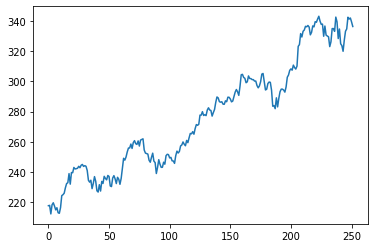

In [37]:
fig = plt.figure()

plt.plot(df.close)


In [38]:
df.columns=["ds","y"]
df.head()

,ds,y
0,2021-01-04,217.69000
1,2021-01-05,217.89999
2,2021-01-06,212.25000
3,2021-01-07,218.28999
4,2021-01-08,219.62000


In [39]:
df.tail()

,ds,y
247,2021-12-27,342.45001
248,2021-12-28,341.25000
249,2021-12-29,341.95001
250,2021-12-30,339.32001
251,2021-12-31,336.32001


# Modelling

### Facebook's Prophet

### Train and Forecast

In [40]:
# Initialize the model
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=365)
# future.tail()

In [42]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
612,2022-12-27,498.428817,455.907676,541.325900
613,2022-12-28,499.025689,455.620765,544.192161
614,2022-12-29,499.595385,454.861885,543.343443
615,2022-12-30,500.876729,455.006010,545.196783
616,2022-12-31,497.910112,450.529886,542.339021


### Visualize forecasts

In [48]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [49]:
plot_components_plotly(m, forecast)

### Evaluate model performance

### Cross Validation


In [54]:
from prophet.diagnostics import cross_validation


In [57]:
df_cv = cross_validation(m, initial='180 days', period='60 days', horizon = '90 days')

INFO:prophet:Making 2 forecasts with cutoffs between 2021-08-03 00:00:00 and 2021-10-02 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [58]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-08-04,291.571475,286.822227,296.401772,286.51001,2021-08-03
1,2021-08-05,292.644814,287.555909,297.549386,289.51999,2021-08-03
2,2021-08-06,293.951819,288.735283,299.275835,289.45999,2021-08-03
3,2021-08-09,295.495638,290.683799,300.957285,288.32999,2021-08-03
4,2021-08-10,295.966922,291.122591,301.099868,286.44000,2021-08-03


In [59]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,56.617790,7.524479,6.721057,0.023306,0.020185,0.022968,0.500000
1,10 days,42.117591,6.489807,6.126488,0.021119,0.018733,0.020870,0.500000
2,11 days,38.103649,6.172815,5.699035,0.019628,0.018733,0.019404,0.541667
3,12 days,35.420770,5.951535,5.495460,0.018867,0.016614,0.018676,0.583333
4,13 days,37.461496,6.120580,5.729840,0.019613,0.018326,0.019433,0.583333


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



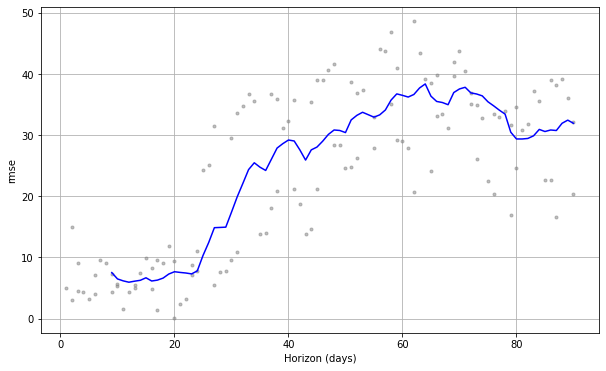

In [60]:
from fbprophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='rmse')